In [1]:
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../StudentPerformanceFactors.csv')

In [3]:
# SANKEY DIAGRAM

def score_group(score):
    if 0 <= score < 60: 
        return '0-59'
    elif 60 <= score < 70: 
        return '60-69'
    elif 70 <= score < 80: 
        return '70-79'
    elif 80 <= score < 90: 
        return '80-89'
    elif 90 <= score <= 100: 
        return '90-100'

df['Score Group'] = df['Exam_Score'].apply(score_group)


layer1 = df.groupby(['School_Type', 'Gender']).size().reset_index(name='count1')
layer2 = df.groupby(['Gender', 'Score Group']).size().reset_index(name='count2')

school_types = sorted(layer1['School_Type'].unique())
genders = sorted(layer1['Gender'].unique())

score_groups = ['0-59', '60-69', '70-79', '80-89', '90-100']

labels = school_types + genders + score_groups
label_to_index = {label: i for i, label in enumerate(labels)}

# Build links for the first and second layers

source1 = layer1['School_Type'].map(label_to_index)
target1 = layer1['Gender'].map(label_to_index)
value1  = layer1['count1']

# 2nd
source2 = layer2['Gender'].map(label_to_index)
target2 = layer2['Score Group'].map(label_to_index)
value2  = layer2['count2']

# combining
source = list(source1) + list(source2)
target = list(target1) + list(target2)
value  = list(value1)  + list(value2)

node_colors = []
for label in labels:
    if label in school_types:
         node_colors.append("blue")
    elif label in genders:
         node_colors.append("green")
    elif label in score_groups:
         node_colors.append("orange")

link_c = "lightgray"
link_colors = [link_c] * len(source)


fig = go.Figure(go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
))

fig.update_layout(
    title_text="Sankey Diagram: School Type → Gender → Score Group",
    font=dict(size=12),
    width=1000,
    height=665,
    margin=dict(l=20, r=20, t=40, b=20)
)

fig.show()


In [4]:
# CORRELATION HEATMAP

df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()

corr_long = corr.reset_index().melt(id_vars='index',
                                     var_name='Feature2',
                                     value_name='Correlation')
corr_long.rename(columns={'index': 'Feature1'}, inplace=True)


heatmap = alt.Chart(corr_long).mark_rect().encode(
    x=alt.X('Feature2:N', 
            title='Features',
            axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Feature1:N', 
            title='Features'),
    color=alt.Color('Correlation:Q',
                    scale=alt.Scale(scheme='redblue', domain=(-0.8, 0.8))),
    tooltip=[
        'Feature1', 
        'Feature2', 
        alt.Tooltip('Correlation:Q', format='.2f')
    ]
).properties(
    width=810,
    height=560,
    title='Feature Correlation Matrix'
)

text = alt.Chart(corr_long).mark_text().encode(
    x='Feature2:N',
    y='Feature1:N',
    text=alt.Text('Correlation:Q', format='.2f'),
    color=alt.condition(
        "datum.Correlation > 0.3 || datum.Correlation < -0.3",
        alt.value('white'),
        alt.value('black')
    )
)


corr_heatmap = heatmap + text
corr_heatmap

#corr_heatmap.save('vis3.html')

alt.LayerChart(...)

/var/folders/hw/_n4hw2nn3l55s0ckr_ym870h0000gn/T/ipykernel_34903/1971342225.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




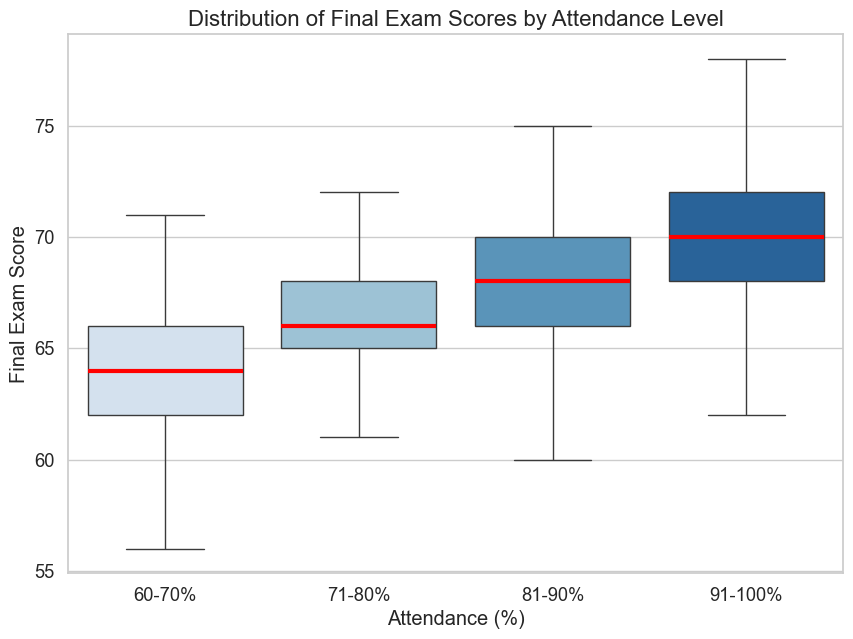

In [5]:
# Attendance Boxplot

bins = [59, 70, 80, 90, 100]
labels = ['60-70%', '71-80%', '81-90%', '91-100%']
df['Attendance_Bin'] = pd.cut(df['Attendance'], bins=bins, labels=labels, include_lowest=True)

# Order for the x-axis categories
category_order = labels

sns.set_theme(style="whitegrid", font_scale=1.2)

medianprops = dict(linestyle='-', linewidth=3, color='red')
plt.figure(figsize=(10, 7))
ax = sns.boxplot(
    x="Attendance_Bin", 
    y="Exam_Score", 
    data=df, 
    order=category_order, 
    palette="Blues",
    medianprops=medianprops,
    showfliers=False
)

ax.set_title("Distribution of Final Exam Scores by Attendance Level", fontsize=16)
ax.set_xlabel("Attendance (%)")
ax.set_ylabel("Final Exam Score")

plt.show()

#plt.savefig("vis5.png")